The code in this notebook is a reimplementation of the classical computing version of the code described in the paper: https://arxiv.org/abs/2304.09224

In [1]:
!pip install torch torchvision
!pip install pennylane

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn as nn
import pennylane as qml

# Data Preparation and Loading

Use the MNIST dataset: https://en.wikipedia.org/wiki/CIFAR-10

In [3]:
# Download and load MNIST dataset

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

# Creating the CNN Architecture

The CNN architecture is defined with two convolutional layers, max pooling layers, and fully connected layers. The forward method specifies how data flows through the network. This architecture is suitable for image classification tasks and can be modified to suit your specific project requirements.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer 1 with 1 input channels (for greyscale images), 16 output channels, and 5x5 kernel
        self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)
        # Batch normalization after convolutional layer 1
        self.bn1 = nn.BatchNorm2d(16)
        # Max pooling layer with a 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
        # Convolutional layer 2 with 16 input channels (from the previous layer), 32 output channels, and 5x5 kernel
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        # Batch normalization after convolutional layer 2
        self.bn2 = nn.BatchNorm2d(32)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        # Propagate the input through the CNN layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Flatten the output from the convolutional layers
        x = x.view(-1, 32 * 7 * 7)
        # Pass the output to the quantum layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the CNN

The CNN model is initialised, the loss function and optimizer are set up, and data loaders for training and validation data are created. The training loop iterates through the dataset for a specified number of epochs, performing forward and backward passes to update the model’s parameters.

In [5]:
dataset  = train_data

cnn = Net()
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)  # Stochastic Gradient Descent optimizer
# Split your data into training and validation sets
train_size = int(0.8 * len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()  # Zero the parameter gradients to avoid accumulation
        outputs = cnn(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters
print('Finished Training')

Finished Training


# Evaluating the Model

Set the model to evaluation mode, use it to make predictions on the validation dataset, and calculate the accuracy of the model.

In [6]:
correct = 0
total = 0
# Set the model to evaluation mode
cnn.eval()
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on the validation set: {100 * correct / total:.2f}%')

Accuracy on the validation set: 98.97%


In [7]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Initialize variables
correct = 0
total = 0
all_labels = []
all_preds = []

# Set the model to evaluation mode
cnn.eval()

# Disable gradient computation for validation
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        
        # Forward pass: get predictions from the model
        outputs = cnn(images)
        
        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update the total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store the labels and predictions for metrics computation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the validation set: {accuracy:.2f}%')

# Calculate precision, recall, F1 score
precision = precision_score(all_labels, all_preds, average='weighted')  # Use 'macro' for unweighted average
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)


Accuracy on the validation set: 98.97%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Confusion Matrix:
[[1164    1    0    0    0    0    1    0    1    0]
 [   0 1374    3    1    0    0    0    5    0    2]
 [   3    2 1165    0    2    0    0   11    1    0]
 [   1    1    4 1198    0    0    1    3    5    3]
 [   0    0    0    0 1175    0    0    0    0    7]
 [   0    0    0    4    0 1033    5    2    6    7]
 [   2    2    1    0    0    1 1159    0    1    0]
 [   0    2    0    0    0    0    0 1272    0    1]
 [   3    3    1    0    3    1    0    2 1112    6]
 [   0    0    0    0    4    2    0    3    3 1225]]


Accuracy on the validation set: 98.97%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


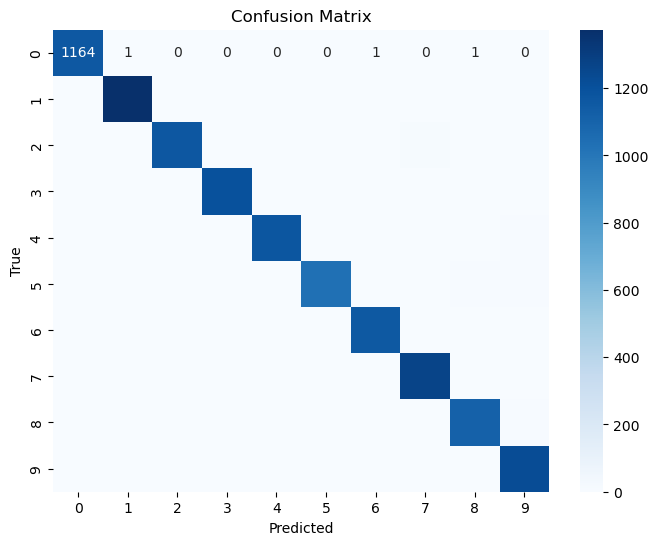

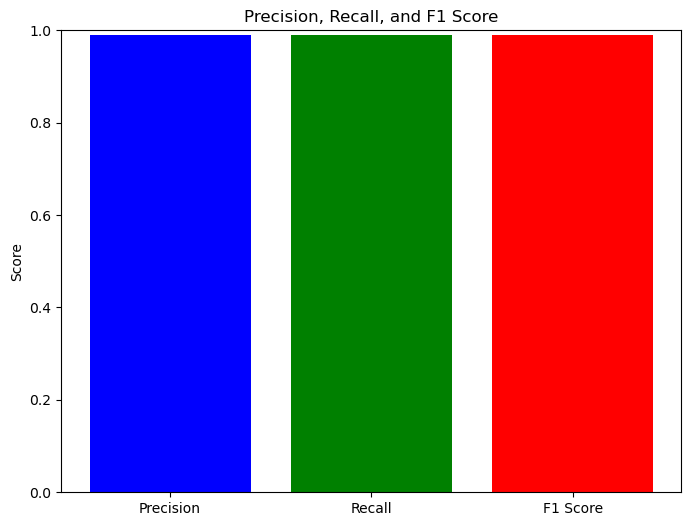

In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Initialize variables
correct = 0
total = 0
all_labels = []
all_preds = []

# Set the model to evaluation mode
cnn.eval()

# Disable gradient computation for validation
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        
        # Forward pass: get predictions from the model
        outputs = cnn(images)
        
        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update the total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store the labels and predictions for metrics computation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the validation set: {accuracy:.2f}%')

# Calculate precision, recall, F1 score
precision = precision_score(all_labels, all_preds, average='weighted')  # 'weighted' to average across classes
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# --- Plotting ---
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 2. Performance Metrics Bar Plot
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 6))
plt.bar(metric_names, metrics, color=['blue', 'green', 'red'])
plt.ylim(0, 1)  # The metrics range from 0 to 1
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.show()

# Optionally, if you're tracking accuracy over epochs:
# accuracy_list = [...]  # A list of accuracy values for each epoch (if tracked)
# plt.plot(accuracy_list, label='Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
